In [356]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path 
import sys 
import os 
import logging
import seaborn as sns
from decimal import Decimal, ROUND_DOWN
import ast 

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, GroupShuffleSplit
from sklearn.metrics import make_scorer ,root_mean_squared_error

from collections import Counter
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold,  cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from skrub import TableVectorizer
import re 

from matplotlib.patches import Patch
import matplotlib as mpl

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import  audit, ml
from helper.transformers import CorrelationSelector,PreserveFeatureNames, PreserveFeatureNamesRegressor


%load_ext autoreload
%autoreload 2

mpl.rcParams['text.usetex'] = False

#shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

info_path = Path(data_root, "files")
#os.listdir(data_derived)

In [358]:
split_chars = "[0_]"
info_dict = {}
qsts = []

for item in os.listdir(info_path):
    if not item.startswith(".")  and not os.path.isdir(Path(info_path, item)):
        name = re.split(split_chars, item)[0]
        qsts.append(name)
        print(name)
        info_dict[name] = pd.read_csv(Path(info_path, item), usecols=['ElementName','DataType', 'ElementDescription'] )
info = pd.DataFrame()
for key, item in info_dict.items():
    info = pd.concat((info, item))


debrief
debrief14
schoolhx
diagpsx
expect
cisp
health
masc
snap
scapijus
cbcl
pcrc
medse
ssrs
wiat
demgr
scid


In [411]:
################## PREDICTORS ####################
pred = pd.read_csv(Path(data_derived, 'mta_data_clean.csv')).drop(columns = 'Unnamed: 0')
out = pd.read_csv(Path(data_derived, 'out_clean_all_raters.csv')).drop(columns = 'Unnamed: 0')
file_name_save = 'results_ML_simple_CV_RF_XGB_ODD.csv'


save_path = Path(data_derived, 'ML_results')
save_path_importances = Path(save_path, "feature_importances")
file_path_save = Path(save_path, file_name_save)

use_params_from_result = True
n_remove_top_features = None
compute_perm_importances = False
save_fig = False
save_importance_df = False



In [360]:
outcome_dict = {'ODD':  "snap_snaoddt", "HYP": "snap_snahypat", "INATT" :"snap_snainatt" , "INTERN": "ssrs_sspintt", "SS": "ssrs_ssptosst", "DOM": "pcrc_pcrcpax", "INTIM": "pcrc_pcrcprx"}
outcome_fig_dict = {'ODD':  "SNAP ODD symptoms", "HYP": "SNAP Hyperactivity Symptoms", "INATT" :"SNAP Inattention Symptoms" , "INTERN": "SSRS Internalizing Symptoms", "SS": "SSRS Social Skills", "DOM": "Parental Dominance", "INTIM": "Parent-Child Intimacy"}
fig_outcome = outcome_fig_dict[file_name_save.split(".")[0].split("_")[-1]]
outcome_name = file_name_save.split(".")[0].split("_")[-1]

In [361]:
save_path_fig = Path("/Users/alina/Desktop/MIT/code/data/output/figures/MLsimpleCV","importances", outcome_name)

In [362]:

if n_remove_top_features is not None : 
    top_features_df = pd.read_csv(Path(save_path_importances, "{}_importances_full.csv".format(outcome_name))).drop(columns="Unnamed: 0")
    top_features2rem =  np.array(top_features_df["features"].iloc[:n_remove_top_features])


In [363]:

if use_params_from_result :
    model_name,  corr_select,   thr_corr, params,  col_out, rater_pred, thr_drop_missing ,r2 = ml.get_params_from_best_result(file_path_save)
    rater_out = col_out[-1]
else: 
    model_name ="RandomForestRegressor" # "XGBRegressor"
    corr_select = True
    thr_corr =0.8
    params = None
    rater_pred = None 
    rater_out = "m"
    thr_drop_missing = 50
    col_out = outcome_dict[file_name_save.split(".")[0].split("_")[-1]] + "_"+ rater_out


original r2 result :  0.3127
model type XGBRegressor
corr_select : correlation_selector {'threshold': 0.8}
thr_corr:  0.8
outcome :  snap_snaoddt_m
rater input data :  m
thr drop missing:  20
params model :  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [364]:
rater_out

'm'

In [365]:

if rater_pred is not None:
    col_pred = [ col for col in pred.columns if col.endswith(rater_pred)]
    col_pred.append("src_subject_id")
    col_pred.append('trtname')
    pred = pred[col_pred]
print(pred.columns)


Index(['expect_exp1_m', 'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m',
       'expect_exp5_m', 'expect_exp6_m', 'expect_exptott_m',
       'snap_snap_adhd_1_m', 'snap_snap_adhd_2_m', 'snap_snap_adhd_3_m',
       ...
       'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m', 'scid_smchk1_m',
       'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m', 'scid_adjchk_m',
       'src_subject_id', 'trtname'],
      dtype='object', length=279)


In [366]:
out_rater = out[['src_subject_id', col_out]]
out_rater = out_rater.rename(columns={col: f"{col}_out" for col in out_rater.columns if col != 'src_subject_id'})

data = pd.merge(out_rater, pred, how = 'left', on = 'src_subject_id')
print(data.keys())
data = audit.remove_cols(data, thr_drop_missing=thr_drop_missing) # adjust if desired, as loaded thr was 50 

y_col = col_out + "_out"
X_cols = [col for col in data.columns if col != y_col]
data = data.dropna(subset=[y_col])

y = np.array(data[y_col])
df_X = data[X_cols].drop(columns='src_subject_id')
if n_remove_top_features is not None : 
    print("removing ", top_features2rem)
    df_X = df_X.drop(columns=top_features2rem)

Index(['src_subject_id', 'snap_snaoddt_m_out', 'expect_exp1_m',
       'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m', 'expect_exp5_m',
       'expect_exp6_m', 'expect_exptott_m', 'snap_snap_adhd_1_m',
       ...
       'scid_axsima_m', 'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m',
       'scid_smchk1_m', 'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m',
       'scid_adjchk_m', 'trtname'],
      dtype='object', length=280)
Index([], dtype='object')
Removing empty columns ..  N =  0
Index([], dtype='object')
(559, 280)
Removing constant columns .. N =  0
Index([], dtype='object')
(559, 280)
Removing known and raw columns..  N =  : 0
[]
(559, 280)
Removing above threshold empty columns.. N =  : 53
{'scid_mala_m', 'scid_certmood_m', 'scid_pastpsy_m', 'cbcl_activities_time2_m', 'scid_edanoa_m', 'cbcl_activities_well2_m', 'scid_pstac_m', 'scid_axsima_m', 'scid_scid19_m', 'scid_certanx_m', 'scid_certsubs_m', 'scid_certadj_m', 'scid_axoca1_m', 'scid_pssom_m', 'scid_sualchk_m', 'scid_e

In [367]:
types_file_path = Path(data_derived, 'all_vars_description_ML.xlsx')
sheet_name='Sheet1'

In [368]:
ord_vars, cat_vars, num_vars, num_vars_in = ml.get_data_types_from_file(data, types_file_path, sheet_name)

Ordinal vars: ['snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_sna26_m', 'snap_sna27_m', 'snap_sna28_m', 'snap_sna29_m', 'snap_sna30_m', 'snap_sna31_m', 'snap_sna32_m', 'snap_sna33_m', 'snap_sna34_m', 'snap_sna35_m', 'snap_sna36_m', 'snap_sna37_m', 'snap_sna38_m', 'snap_sna39_m', 'snap_snap_adhd_1_m', 'snap_snap_adhd_11_m', 'snap_snap_adhd_12_m', 'snap_snap_adhd_13_m', 'snap_snap_adhd_14_m', 'snap_snap_adhd_15_m', 'snap_snap_adhd_16_m', 'snap_snap_adhd_17_m', 'snap_snap_adhd_18_m', 'snap_snap_adhd_19_m', 'snap_snap_adhd_2_m', 'snap_snap_adhd_3_m', 'snap_snap_adhd_4_m', 'snap_snap_adhd_5_m', 'snap_snap_adhd_6_m', 'snap_snap_adhd_7_m', 'snap_snap_adhd_8_m', 'snap_snap_adhd_9_m', 'snap_snap_adhd_11_m', 'snap_snap_adhd_12_m', 'snap_snap_adhd_13_m', 'snap_snap_adhd_14_m', 'snap_snap_adhd_15_m', 'snap_snap_adhd_16_m', 'snap_snap_adhd_17_m', 'snap_snap_adhd_18_m', 'snap_snap_adhd_19_m', 'ssrs_s7t35_m', 'ssrs_s7t36_m', 'ssrs

/Users/alina/Desktop/MIT/code/ADHD/MTA/helper/ml.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_name = row[1]  # e.g. variable name in the spreadsheet
/Users/alina/Desktop/MIT/code/ADHD/MTA/helper/ml.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_type = row[4]  # e.g. "ord" / "num" / "cat"


In [369]:
if n_remove_top_features is not None : 
    for lst in [ord_vars, cat_vars, num_vars, num_vars_in]:
        lst[:] = [x for x in lst if x not in top_features2rem]
        

In [370]:
ml.check_overlap(num_vars_in, ord_vars, cat_vars)

Overlaps between numeric and ordinal: set()
Overlaps between numeric and categorical: set()
Overlaps between ordinal and categorical: set()
Overlaps across numeric, ordinal and categorical: set()


In [371]:
# to_remove = ['masc_ma22acx_c', 'masc_ma31hfx_c']
# ord_vars.remove(to_remove[0])
# ord_vars.remove(to_remove[1])

In [372]:

cat_vars_str, cat_vars_num, rest = [], [], []

for col in cat_vars:
    # Get the first non-null value in the column
    val = data[col].dropna().unique()[0]
    
    # Check if it's a (Python or NumPy) string
    if isinstance(val, (str, np.str_)):
        cat_vars_str.append(str(col))  # ensure column name is a Python str
    # Check if it's a (Python or NumPy) float
    elif isinstance(val, (float, np.floating)):
        cat_vars_num.append(str(col))  # ensure column name is a Python str
    else:
        rest.append(str(col))          # store in `rest` for debugging
print(cat_vars_str)
print(cat_vars_num)

['trtname']
['scid_axisidx_m', 'cbcl_special_ed_m', 'cbcl_repeat_grade_m', 'cbcl_academic_m']


In [373]:
# Define the extensions to check
extensions = ['_m', #mother 
              #'_p'# proffesionals
              '_f', # father,
              '_c',# child,
              '_t'] # teacher 

# Count columns for each extension
extension_counts = {ext: sum(col.endswith(ext) for col in pred.columns) for ext in extensions}

for ext, count in extension_counts.items():
    print(f"Columns ending with '{ext}': {count}")
    
dup_cols = df_X.columns[df_X.columns.duplicated()]
print("Duplicated column names:", dup_cols.tolist())




Columns ending with '_m': 277
Columns ending with '_f': 0
Columns ending with '_c': 0
Columns ending with '_t': 0
Duplicated column names: []


In [374]:
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

groups = data['src_subject_id'].values

group_kfold = GroupKFold(n_splits=5)

In [375]:
if params is not None :  
    if model_name == "RandomForestRegressor":
        regress = RandomForestRegressor(random_state=42, **params)
    elif model_name == 'XGBRegressor':
        regress =  XGBRegressor(random_state=42, **params)
    else: 
        raise ValueError
        
else:
    if model_name == 'RandomForestRegressor':
        param_distributions = {
            'regressor__n_estimators': [100, 300],          # Correct prefix
            'regressor__max_depth': [10, None],
            'regressor__min_samples_split': [2, 10],
            'regressor__min_samples_leaf': [1, 4]
        }
        regress =  RandomForestRegressor(random_state=42)

    elif model_name == 'XGBRegressor':
        regress =  XGBRegressor(random_state=42)
        if params is None:
            param_distributions = {
            'regressor__n_estimators': [100, 300],
            'regressor__max_depth': [10],                    # Removed None
            'regressor__colsample_bytree': [0.5, 0.3],       # Mapped 'sqrt' and 'log2' to numeric values
            'regressor__min_child_weight': [2, 10, 1, 4],    # Combined 'min_samples_split' and 'min_samples_leaf'
        }

print(regress)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


## Add grid search here 

In [376]:

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler',StandardScaler())
])

ord_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='mean'))),
    ('identity', PreserveFeatureNames(FunctionTransformer(lambda x: x)))
])


cat_to_dataframe = FunctionTransformer(
    func=lambda X: pd.DataFrame(X, columns=cat_vars_str),
    validate=False  # prevent extra validation that may alter the input
)

cat_str_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='constant', fill_value='missing'))),
    #('to_df', cat_to_dataframe),        # conversion step added
     ('ohe', PreserveFeatureNames(TableVectorizer()))
])

cat_num_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='constant', fill_value=-1))),
    ('ohe', PreserveFeatureNames(OneHotEncoder(handle_unknown="ignore")))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_vars_in),
    ('cat_str', cat_str_pipe, cat_vars_str),
    ('cat_num', cat_num_pipe, cat_vars_num),
    ('ord', ord_pipe, ord_vars)
])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
   # ('to_df', to_df_transformer),
   ('correlation_selector', CorrelationSelector(threshold=0.8)),
   #('to_df',ToDataFrameTransformer(preprocessor=preprocessor)),
    ('regressor',regress)
])


scoring = {
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error',
    'r2': 'r2'
}

cv_results = cross_validate(pipeline, df_X, y, cv=group_kfold, scoring=scoring, groups=groups,     return_estimator=True,)
best_index = np.argmax(cv_results['test_r2'])
best_pipeline = cv_results['estimator'][best_index]




/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns 

In [ ]:
mean_mae = - ml.truncate(cv_results['test_neg_mae'].mean(), 4)
mean_mse = -ml.truncate(cv_results['test_neg_mse'].mean(), 4)
mean_r2 = ml.truncate(cv_results['test_r2'].mean(), 4)


print("Mean MAE", mean_mae)
print("Mean MSE:", mean_mse)
print("Mean R2:", mean_r2)

Mean MAE 3.6647
Mean MSE: 22.0097
Mean R2: 0.3127


In [442]:
mse_dist = - cv_results['test_neg_mae']
mae_dist = - cv_results['test_neg_mse']
r2_dist = cv_results['test_r2']

In [378]:
for est in cv_results["estimator"]:
    print(id(est))

13031991680
13031982512
13031993168
13031992832
6380112384


In [379]:

if compute_perm_importances: 
    n_repeats = 10
    print("Computing permutation feature importances...")
    print("N repeats : {}".format(n_repeats))
    fold_splits = list(group_kfold.split(df_X, y, groups))
    perm_importances = []
    

    # Compute permutation importance on each fold using the R² metric
    for fold_idx, (train_idx, test_idx) in enumerate(fold_splits):
        estimator = cv_results['estimator'][fold_idx]
        X_test, y_test = df_X.iloc[test_idx], y[test_idx]
        result = permutation_importance(
            estimator, X_test, y_test,
            n_repeats=n_repeats, random_state=42,
            scoring='r2'
        )
        perm_importances.append(result.importances_mean)
        #print(perm_importances)

    # Average permutation importances across folds
    importances= np.mean(perm_importances, axis=0)
    print("Average Permutation Importances (using R²):", importances)
#pipeline.fit(df_X, y)
else: 
    print("Using models internal feature importances ...")
    importances= best_pipeline.named_steps['regressor'].feature_importances_

Using models internal feature importances ...


In [380]:
# Define the extensions to check
extensions = ['m', #mother 
              #'_p'# proffesionals
              'f', # father,
              'c',# child,
              't'] # teacher 

# Count columns for each extension



In [403]:
rater_pred_fig = rater_pred if rater_pred is not None else "all"
rater_pred_fig

model_name_fig = "Random Forest Regressor" if model_name == "RandomForestRegressor"else "XGB Regressor"

In [408]:
def get_name_save(outcome_name, compute_perm_importances, n_remove_top_features, ext):

    perm_name = "_perm10" if compute_perm_importances else "_noperm"
    rem_feat_name = "_rem{}feat".format(n_remove_top_features) if n_remove_top_features is not None else "_allfeat"
    fig_name = outcome_name +  "_imp" + perm_name + rem_feat_name + ext
    return fig_name

def get_fig_title(top_n, rater_dict, rater_out,  n_remove_top_features, compute_perm_importances):
    perm_title = "Permutation Feature Importances" if compute_perm_importances else "Feature Importances"
    rem_feat_title = "" if n_remove_top_features is None else "after removing {} top features"if n_remove_top_features > 1 else "after removing the top feature"
    
    title = "Top {} {} for predicting {} at 14 months rated by {} \n {}".format(
    top_n, 
    perm_title,
    fig_outcome, 
    rater_dict[rater_out],
    rem_feat_title)
    return title 



{'m': 296, 'f': 0, 'c': 0, 't': 0}


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_3957/1474573994.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_labels, rotation=45, ha='right')


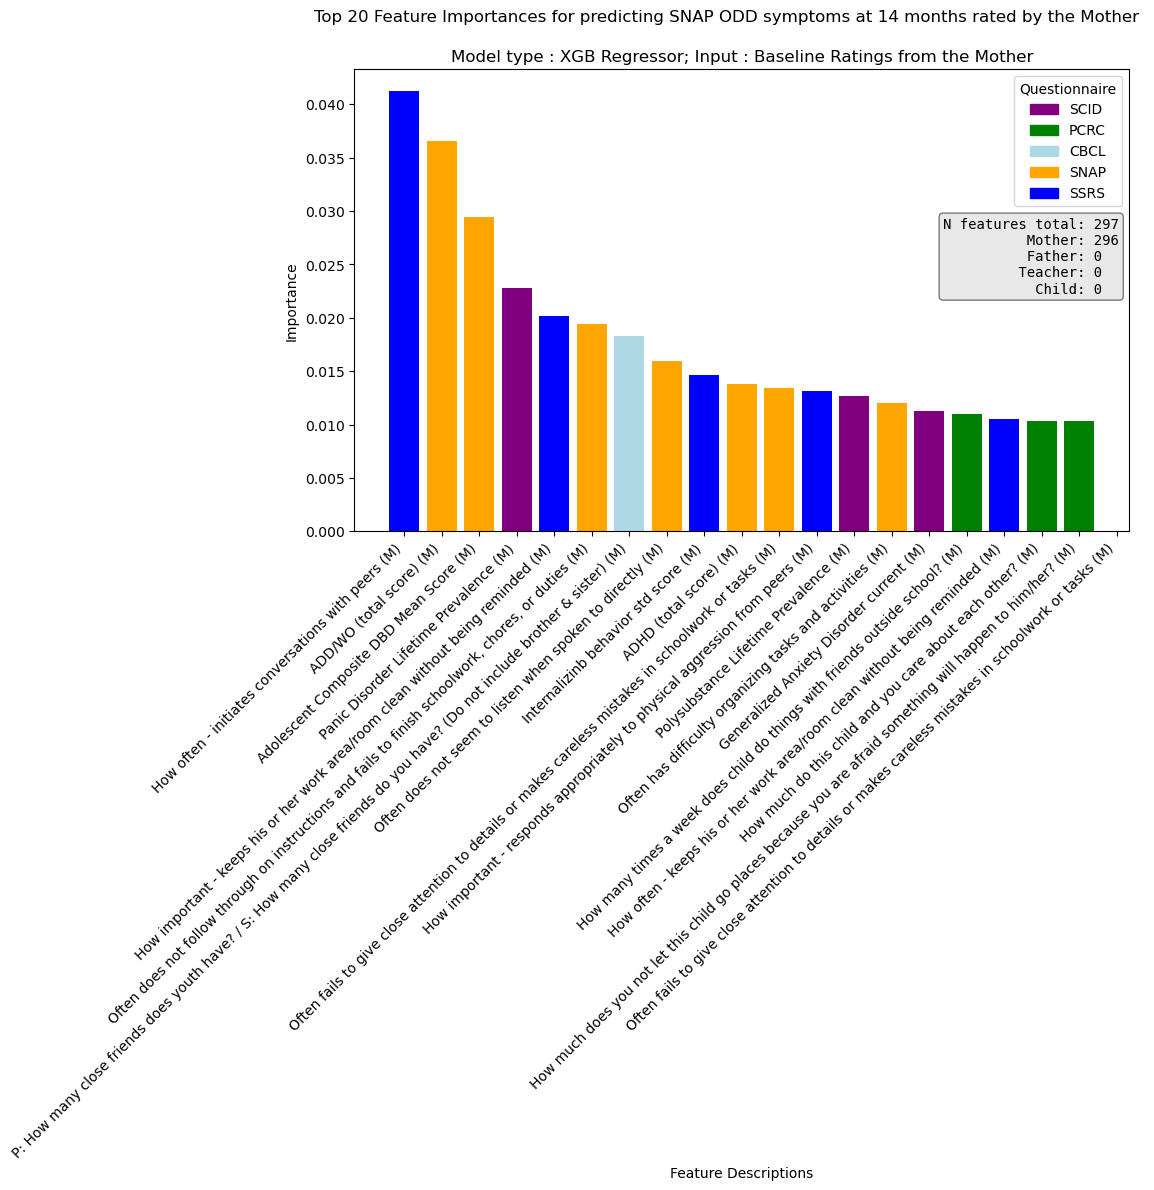

In [ ]:



# Get processed feature names and importances.
processed_feature_names = best_pipeline["preprocessor"].get_feature_names_out()
# importance = pipeline.named_steps['regressor'].feature_importances_
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]
top_feature_names = processed_feature_names[indices]
top_importances = importances[indices]

# Count extensions (assumes extensions is defined, e.g. extensions = ["m", "f", "t", "c", "n"])
extension_counts = {ext: sum(col.endswith(ext) for col in processed_feature_names) for ext in extensions}
print(extension_counts)

# Build a support text using plain text with aligned keys.
support_data = {
    "N features total": len(processed_feature_names),
    "Mother": extension_counts.get("m", 0),
    "Father": extension_counts.get("f", 0),
    "Teacher": extension_counts.get("t", 0),
    "Child": extension_counts.get("c", 0)
}
max_key_len = max(len(key) for key in support_data.keys())
lines = []
for key, value in support_data.items():
    # Right-align the keys so the colon lines up.
    line = "{:>{width}}: {}".format(key, value, width=max_key_len)
    lines.append(line)
support_text = "\n".join(lines)

# Define questionnaire colors.
questionnaire_colors = {
    'SNAP': 'orange',
    'SSRS': 'blue',
    'PCRC': 'green',
    'SCID': 'purple',
    'CBCL': 'lightblue',
    "MASC": "red",
    "EXPECT": "gray"
}

rater_dict = {
    "m": "the Mother", 
    "f": "the Father",
    "t": "the Teacher",
    "c": "the Child",
    "all": "All Raters"
}

def clean_description(description, questionnaires):
    # Remove a leading number and following non-letter characters.
    description = re.sub(r'^\d+[^A-Za-z]*', '', description)
    # Remove any questionnaire name (case-insensitive) at the start along with following non-letter characters.
    for q in questionnaires:
        pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
        description = pattern.sub('', description)
    return description.strip()

def get_description(var_name, info):
    match = info[info['ElementName'].apply(lambda x: x in var_name)]
    description = match.iloc[0]['ElementDescription'] if not match.empty else var_name
    return clean_description(description, list(questionnaire_colors.keys()))

final_labels = []
bar_colors = []
questionnaires_found = set()

for feature in top_feature_names:
    # Expected format: type__questionnaire_varname_rater
    parts = feature.split('__')
    if len(parts) == 2:
        rest_parts = parts[1].split('_')
        if len(rest_parts) >= 3:
            questionnaire = rest_parts[0].upper()
            rater = rest_parts[-1].upper()
            var_name = '_'.join(rest_parts[1:-1])
            description = get_description(var_name, info)
            # If the rater is not 'C', and the description contains both Child and Parent parts,
            # extract only the Parent part (remove the literal "Parent.").
            if rater != 'C':
                parent_match = re.search(r'(?i)Parent\.\s*(.*)', description)
                if parent_match:
                    description = parent_match.group(1).strip()
            label = f"{description} ({rater})"
            final_labels.append(label)
            color = questionnaire_colors.get(questionnaire, 'grey')
            bar_colors.append(color)
            questionnaires_found.add(questionnaire)
        else:
            final_labels.append(feature)
            bar_colors.append('grey')
    else:
        final_labels.append(feature)
        bar_colors.append('grey')

# Create figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart.
ax.bar(final_labels, top_importances, color=bar_colors)
ax.set_xlabel("Feature Descriptions")
ax.set_ylabel("Importance")
ax.set_xticklabels(final_labels, rotation=45, ha='right')

# Set the titles.
title = get_fig_title(top_n, rater_dict, rater_out, n_remove_top_features, compute_perm_importances)
fig.suptitle(title)
#fig.suptitle("Top {} Feature Importances for predicting {} at 14 months rated by {}".format(
  #  top_n, fig_outcome, rater_dict[rater_out]))
ax.set_title("Model type : {}; Input : Baseline Ratings from {}".format( model_name_fig,
    rater_dict[rater_pred_fig]))

ax.set_xticks(range(len(final_labels)))
ax.set_xticklabels(final_labels, rotation=45, ha='right')
# Add the support text box (using plain text with monospace font).
ax.text(0.76,0.68, support_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

# Create a legend for the questionnaires.
legend_handles = [Patch(color=questionnaire_colors.get(q, 'grey'), label=q) for q in questionnaires_found]
ax.legend(handles=legend_handles, title="Questionnaire",loc='upper right', bbox_to_anchor=(1, 1) )

if save_fig:

    fig_name = get_name_save(outcome_name, compute_perm_importances, n_remove_top_features, ".png")
    print("Saving to path {}".format(save_path_fig))
    if not os.path.exists(save_path_fig):
        os.makedirs(save_path_fig)
    plt.savefig(Path(save_path_fig, fig_name ), bbox_inches='tight')

plt.show()

In [384]:

sorted_indices = np.argsort(importances)
top_indices = sorted_indices[-top_n:]
sorted_feature_names = processed_feature_names[sorted_indices]
#top_importances = importances[top_indices]

In [385]:
sorted_feature_names

array(['ord__ssrs_s7t35_m', 'ord__snap_snap_adhd_17_m',
       'ord__snap_snap_adhd_16_m', 'ord__snap_snap_adhd_9_m',
       'ord__snap_snap_adhd_8_m', 'ord__snap_snap_adhd_2_m',
       'num__pcrc_pcrcpox_m', 'num__pcrc_pcrcwx_m', 'num__pcrc_pcrcpax_m',
       'ord__snap_snap_adhd_15_m', 'num__pcrc_pcrcdwx_m',
       'num__expect_exptott_m', 'cat_str__trtname',
       'ord__cbcl_school1b_m', 'cat_num__scid_axisidx_m',
       'cat_num__cbcl_repeat_grade_m', 'cat_num__cbcl_academic_m',
       'ord__snap_sna19_m', 'ord__snap_sna20_m', 'ord__snap_sna39_m',
       'ord__snap_sna22_m', 'ord__snap_sna23_m', 'ord__snap_sna24_m',
       'ord__snap_sna25_m', 'ord__snap_sna26_m', 'ord__snap_sna27_m',
       'ord__snap_sna28_m', 'cat_num__cbcl_special_ed_m',
       'ord__snap_sna29_m', 'ord__ssrs_sst16_m', 'ord__expect_exp1_m',
       'ord__cbcl_interp_siblings_m', 'ord__cbcl_friends_time_m',
       'ord__scid_q088_agor_life_m', 'ord__scid_q079_hal_life_m',
       'ord__scid_undfsomc_m', 'ord__sci

In [386]:
idx_impo_all = np.argsort(importances)[::-1][:-1]
top_feature_names_all = processed_feature_names[idx_impo_all]
top_importances_all = importances[idx_impo_all]

In [425]:
prefixes = ['num__','cat_str__','cat_num__', 'ord__']
pattern = re.compile(r'^(' + '|'.join(map(re.escape, prefixes)) + ')')
top_feature_names_all_short= [pattern.sub('', name) for name in top_feature_names_all]
columns = ["features","features_model" , "importances"]
importances_df = pd.DataFrame({"features": top_feature_names_all_short ,"features_model": top_feature_names_all, "importanecs": top_importances_all})
table_name = get_name_save(outcome_name +"_sorted", compute_perm_importances, n_remove_top_features, ".csv")
print(importances_df)
if save_importance_df : 
    importances_df.to_csv(Path(save_path_importances, table_name))

                   features               features_model  importanecs
0              ssrs_s7t71_m            ord__ssrs_s7t71_m     0.041199
1           snap_snaaddwt_m         num__snap_snaaddwt_m     0.036512
2            snap_snadbdx_m          num__snap_snadbdx_m     0.029399
3    scid_q085_panic_life_m  ord__scid_q085_panic_life_m     0.022827
4              ssrs_s7t45_m            ord__ssrs_s7t45_m     0.020207
..                      ...                          ...          ...
188      snap_snap_adhd_2_m      ord__snap_snap_adhd_2_m     0.000000
189      snap_snap_adhd_8_m      ord__snap_snap_adhd_8_m     0.000000
190      snap_snap_adhd_9_m      ord__snap_snap_adhd_9_m     0.000000
191     snap_snap_adhd_16_m     ord__snap_snap_adhd_16_m     0.000000
192     snap_snap_adhd_17_m     ord__snap_snap_adhd_17_m     0.000000

[193 rows x 3 columns]


In [447]:
## results table here 



params_RF = ['n_estimators', 'criterion', 'max_depth', 'max_features']
params_XGB = [ 'n_estimators', 'learning_rate','max_depth', 'max_leaves', 'tree_method' ]


cols_res_mean = ['Model Name', 
              'Mean Squared Error - Mean Across Folds', 
              'Mean Absolute Error - Mean Across Folds',
              'R² Score - Mean Across Folds', 
              'N Top Features Removed', 
              'Number of Features per Rater']

cols_res_dist = ['Model Name', 
              'Mean Squared Error - Distribution',
              'Mean Absolute Error - Distribution',
              'R² Score - Distribution', 
              'N Top Features Removed', 
              'Number of Features per Rater',
              "P Value"]

In [465]:
n_features_removed = n_remove_top_features if n_remove_top_features is not None else 0
formatted_support = "\n".join(f"{k}: {v}" for k, v in support_data.items())

In [470]:

new_row_mean = dict(zip(cols_res_mean, [model_name, mean_mse, mean_mae, mean_r2, n_features_removed, formatted_support]))
new_row_dist = dict(zip(cols_res_dist, [model_name, mse_dist, mae_dist, r2_dist, n_features_removed, formatted_support]))

In [ ]:
df_result = pd.DataFrame(columns= cols_res_dist)
result_df = pd.concat([df_result, pd.DataFrame([new_row_dist])], ignore_index=True)



In [474]:
table_name

'ODD_sorted_imp_noperm_allfeat.csv'

In [468]:
if os.path.exists(file_path_save):
    df_result  = pd.read_csv(Path(data_derived, 'ML_results', file_name_save))
    #df_result.columns = cols_res
    print(df_result.columns)
    if 'Unnamed: 0' in df_result.columns:
        df_result = df_result.drop(columns= 'Unnamed: 0')
else:
    df_result = pd.DataFrame(columns= cols_res)
    

try: 
    if not ((df_result == new_row).all(axis=1)).any() :
        result_df = pd.concat([df_result, pd.DataFrame([new_row])], ignore_index=True)
        
    else: 
        print('ROW ALREADY EXISTS')
        result_df = df_result


except IndexError as e:
    if str(e) == 'single positional indexer is out-of-bounds':
        result_df = pd.DataFrame([new_row])

result_df[-20:]

Index(['Unnamed: 0', 'Model Name', 'Cross Validation Type', 'Hyperparameters',
       'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error',
       'R² Score', 'Outcome Variable', 'Input Data',
       'Feature Selection Method', 'Number of Features', 'Threshold Drop Row'],
      dtype='object')


NameError: name 'new_row' is not defined

Need 
- model name 
- mean MAE + list 
- mean MSE + list  
- mean R2 + list  
- Support per rater 
- perm or no perm + N perm 
- N feature removed 
- p val difference with no removal dist

Constant 
- hyperparams 
- outcome 
- input 
- thrshold drop row 
- cross val type 

In [424]:
print(model_name,  mean_mae, mean_mse, mean_r2)

XGBRegressor -3.6647063143378906 -22.009760394123777 0.3127578913019903


In [422]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_neg_mae', 'test_neg_mse', 'test_r2'])

In [ ]:
rmse = - ml.truncate(best_results['mean_test_rmse'], 4)
mse =  ml.truncate(best_results['mean_test_rmse'] ** 2, 4)
mae = - ml.truncate(best_results['mean_test_mae'], 4)
r2 =ml.truncate(best_results['mean_test_r2'], 4)

